<a href="https://colab.research.google.com/github/olakoja/DA-MUS/blob/main/%D0%A0%D0%B0%D1%81%D1%87%D1%91%D1%82_%D0%BF%D0%B0%D1%80%D0%BA%D0%BE%D0%B2%D0%BE%D0%BA_%D0%B8_%D0%BE%D0%B7%D0%B5%D0%BB%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B2_%D0%BD%D0%B5_%D0%BC%D0%B5%D1%81%D1%82%D0%B0%D1%85_%D0%B2%D1%82%D0%BE%D1%80%D0%BE%D0%B9_%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка библиотек

In [1]:
# Инсталяция и импорт
!pip install osmnx -qq
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.validation import make_valid
from shapely.ops import unary_union
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 2.2 MB/s eta 0:00:00


# Загрузка и фильтрация данных

Всего полигонов: 6851
Отфильтровано полигонов: 66


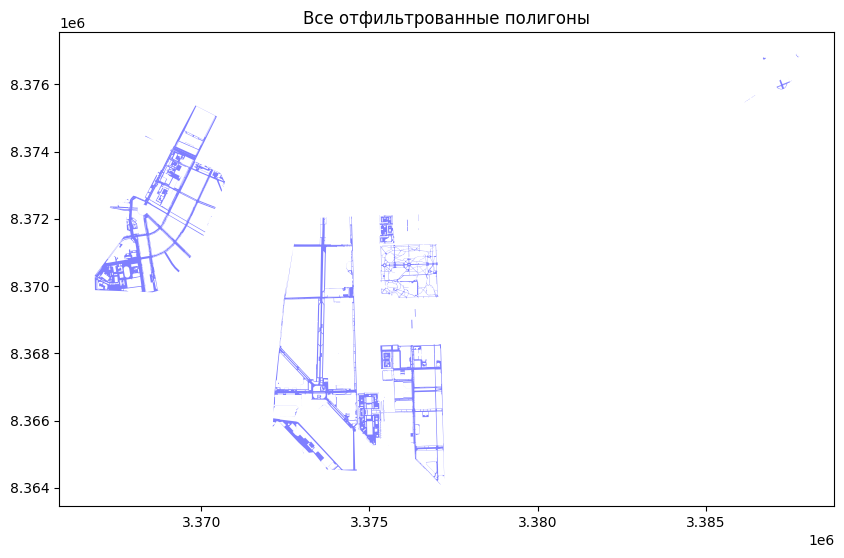

In [2]:
# Загрузка данных
gdf = gpd.read_file('/content/output_b (2).gpkg').to_crs("EPSG:3857")
print(f"Всего полигонов: {len(gdf)}")
# Фильтрация полигонов
filtered_gdf = gdf[(gdf['bench_density'] >= 0.01) & (gdf['bench_density'] <= 0.1) & (gdf['non-place1'] == 'non-place')].copy()
print(f"Отфильтровано полигонов: {len(filtered_gdf)}")
# Визуализация отфильтрованных полигонов
filtered_gdf.plot(color='blue', alpha=0.5, figsize=(10, 10))
plt.title("Все отфильтрованные полигоны")
plt.show()

После обработки геометрии: 66 полигонов


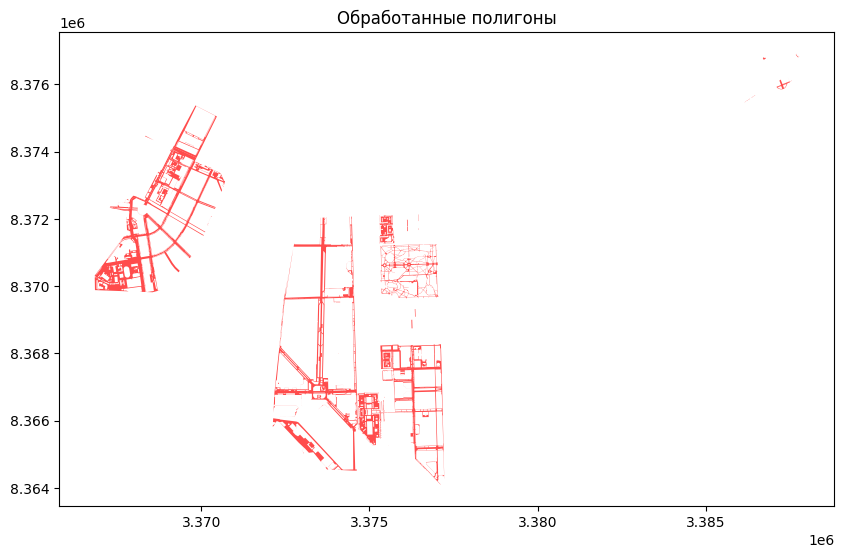

/tmp/ipython-input-3-3575227974.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_polygon = processed_gdf.geometry.unary_union


In [3]:
# Обработка полигонов
processed_geoms = [make_valid(geom) if not geom.is_valid else geom for geom in filtered_gdf.geometry]
processed_gdf = gpd.GeoDataFrame(geometry=processed_geoms, crs="EPSG:3857")
print(f"После обработки геометрии: {len(processed_gdf)} полигонов")
# Визуализация обработанных полигонов
processed_gdf.plot(color='red', alpha=0.7, figsize=(10, 10))
plt.title("Обработанные полигоны")
plt.show()
# Сохранение обработанных полигонов
processed_gdf.to_file("processed_polygons.gpkg", driver="GPKG")
# Объединение полигонов в один (облегчение алгоритма)
processed_gdf = processed_gdf.to_crs(epsg=4326)
combined_polygon = processed_gdf.geometry.unary_union

Подготовка данных для анализа дорог: загрузка данных о путях сообщения на территории и формирование требований минимальной ширины дорог по государственным нормативам (региональные имеют болшую силу, если превосходят федеральные)

In [4]:
# Список тэгов для запроса к OSM
tags = {
    'highway': ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'residential', 'service', 'footway', 'pedestrian', 'path', 'cycleway']
}

features_gdf = ox.features.features_from_polygon(polygon=combined_polygon, tags=tags)
features_gdf = features_gdf.drop_duplicates(subset='geometry', keep='first')
print(f"Строк: {len(features_gdf)}")
# Функция для определения минимальной ширины дороги
def get_min_width(osm_feature_row):
    highway_type = osm_feature_row.get('highway', None)
    return {
        'motorway': 3.5, 'trunk': 3.5, 'primary': 3.5,
        'secondary': 3.0, 'tertiary': 3.0,
        'residential': 2.75, 'unclassified': 2.75,
        'service': 2.5, 'footway': 1.5,
        'cycleway': 1.2
    }.get(highway_type, 1.0)
# Добавление ширины в GeoDataFrame
features_gdf['min_width'] = features_gdf.apply(get_min_width, axis=1)
features_gdf['buffer_geom'] = features_gdf.apply(lambda row: row['geometry'].buffer(row['min_width']), axis=1)

Строк: 3676


## Визуализация скаченных дорог

Создание и применение цыетовой схемы

In [5]:
# Цветовая схема
road_colors = {
    'motorway': '#FF0000',
    'trunk': '#FF4500',
    'primary': '#FF8C00',
    'secondary': '#FFA500',
    'tertiary': '#FFD700',
    'residential': '#4682B4',
    'service': '#708090',
    'footway': '#32CD32',
    'cycleway': '#00BFFF',
    'default': '#A9A9A9'
}

def get_road_color(highway_type):
    return road_colors.get(highway_type, road_colors['default'])

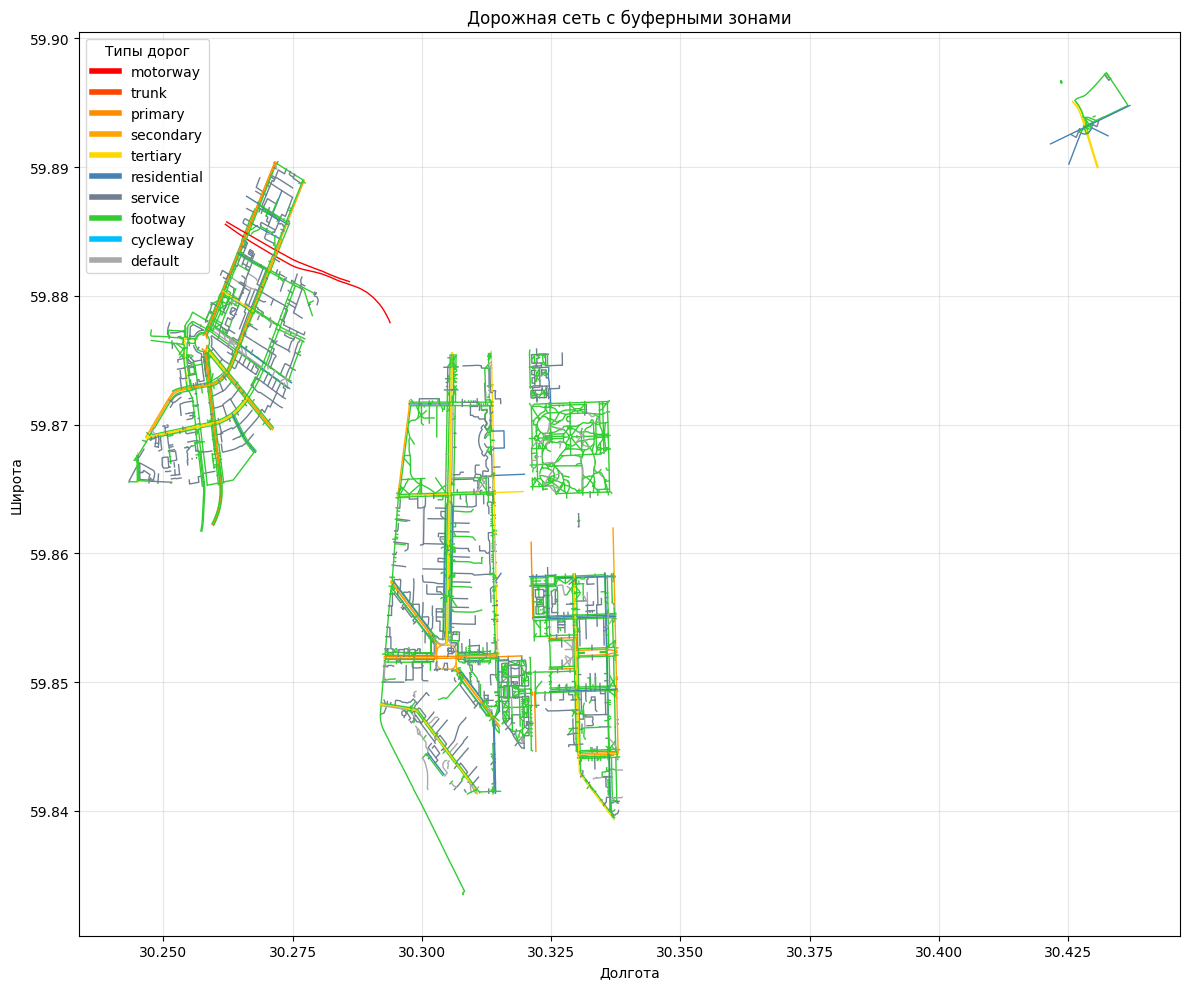

In [6]:
# Визуализация. Карта
fig, ax = plt.subplots(figsize=(12, 10))
for idx, row in features_gdf.iterrows():
    color = get_road_color(row.get('highway', 'default'))
    if row['geometry'].geom_type in ['LineString', 'MultiLineString']:
        ax.plot(*row['geometry'].xy, color=color, linewidth=1)
    else:
        ax.fill(*row['geometry'].exterior.xy, color=color, alpha=0.3)

# Легенда и оформление
handles = []
labels = []
for htype, color in road_colors.items():
    handles.append(plt.Line2D([0], [0], color=color, lw=4))
    labels.append(htype)

ax.legend(handles, labels, title='Типы дорог')
ax.set_title('Дорожная сеть с буферными зонами')
ax.set_xlabel('Долгота')
ax.set_ylabel('Широта')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Расчёт площади, освобождённой от транзитивности

In [7]:
# Целевая плотность точек (0.1 точек на м²)
TARGET_DENSITY = 0.1

# Переведем все в метрическую CRS для точных расчетов
metric_crs = 'EPSG:32637'  # UTM (подберите под вашу зону)
processed_gdf = filtered_gdf.to_crs(metric_crs)
features_gdf = features_gdf.to_crs(metric_crs)

# Рассчитаем фактическое количество точек в каждом полигоне
processed_gdf['bench_count'] = processed_gdf['bench_density'] * processed_gdf.geometry.area # Расчёт количества точек в полигоне
processed_gdf['target_buffer_area'] = processed_gdf['bench_count'] / TARGET_DENSITY # Расчёт площади, при которой произойдёт сгущение точек до целевой плотности

result_polygons = []

for idx, polygon_row in processed_gdf.iterrows():
    current_polygon = polygon_row.geometry
    roads_in_polygon = features_gdf[features_gdf.intersects(current_polygon)].copy()

    if roads_in_polygon.empty:
        result_polygons.append(polygon_row)  # если дорог нет, оставляем полигон как есть
        continue

    # Обрезаем дороги по границе полигона
    roads_in_polygon['clipped_geom'] = roads_in_polygon.geometry.intersection(current_polygon)
    roads_in_polygon = roads_in_polygon[~roads_in_polygon['clipped_geom'].is_empty]

    if roads_in_polygon.empty:
        result_polygons.append(polygon_row)
        continue

    # Рассчитываем суммарную длину дорог в полигоне (исключаем нулевые длины)
    total_road_length = roads_in_polygon['clipped_geom'].length.sum()

    # Защита от деления на ноль и некорректных значений
    if total_road_length <= 0 or not np.isfinite(total_road_length):
        result_polygons.append(polygon_row)
        continue

    # Требуемая ширина буфера (без учёто нормативов)
    required_width = polygon_row['target_buffer_area'] / total_road_length

    # Проверяем, что ширина конечная и положительная
    if not np.isfinite(required_width) or required_width <= 0:
        required_width = 0.0  # или иное минимальное допустимое значение

    # Создаем буферы с учетом нормативов
    buffered_roads = []
    for _, road_row in roads_in_polygon.iterrows():
        normative_width = get_min_width(road_row)  # нормативная ширина из вашей функции
        final_width = max(required_width, normative_width)  # выбираем наибольшую (необходимая <=> нормативной)

        # Дополнительная проверка на корректность ширины
        if not np.isfinite(final_width) or final_width <= 0:
            final_width = normative_width  # используем норматив, если расчетная ширина некорректна

        try:
            buffered_road = road_row['clipped_geom'].buffer(final_width)
            buffered_roads.append(buffered_road)
        except Exception as e:
            print(f"Ошибка при создании буфера: {e}. Используется нормативная ширина {normative_width}.")
            buffered_road = road_row['clipped_geom'].buffer(normative_width)
            buffered_roads.append(buffered_road)

    # Объединяем все буферы и вычитаем из исходного полигона
    if buffered_roads:  # если есть буферы для объединения
        combined_buffer = unary_union(buffered_roads)
        remaining_polygon = current_polygon.difference(combined_buffer)

        if not remaining_polygon.is_empty:
            new_row = polygon_row.copy()
            new_row.geometry = remaining_polygon
            result_polygons.append(new_row)

# Собираем результат
result_gdf = gpd.GeoDataFrame(result_polygons, crs=metric_crs)

## Вывод результатов расчётов

Исходная площадь: 1917468 м²
Оставшаяся площадь: 732907 м²
Процент сохраненной площади: 38.2%


/tmp/ipython-input-8-20869505.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipython-input-8-20869505.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


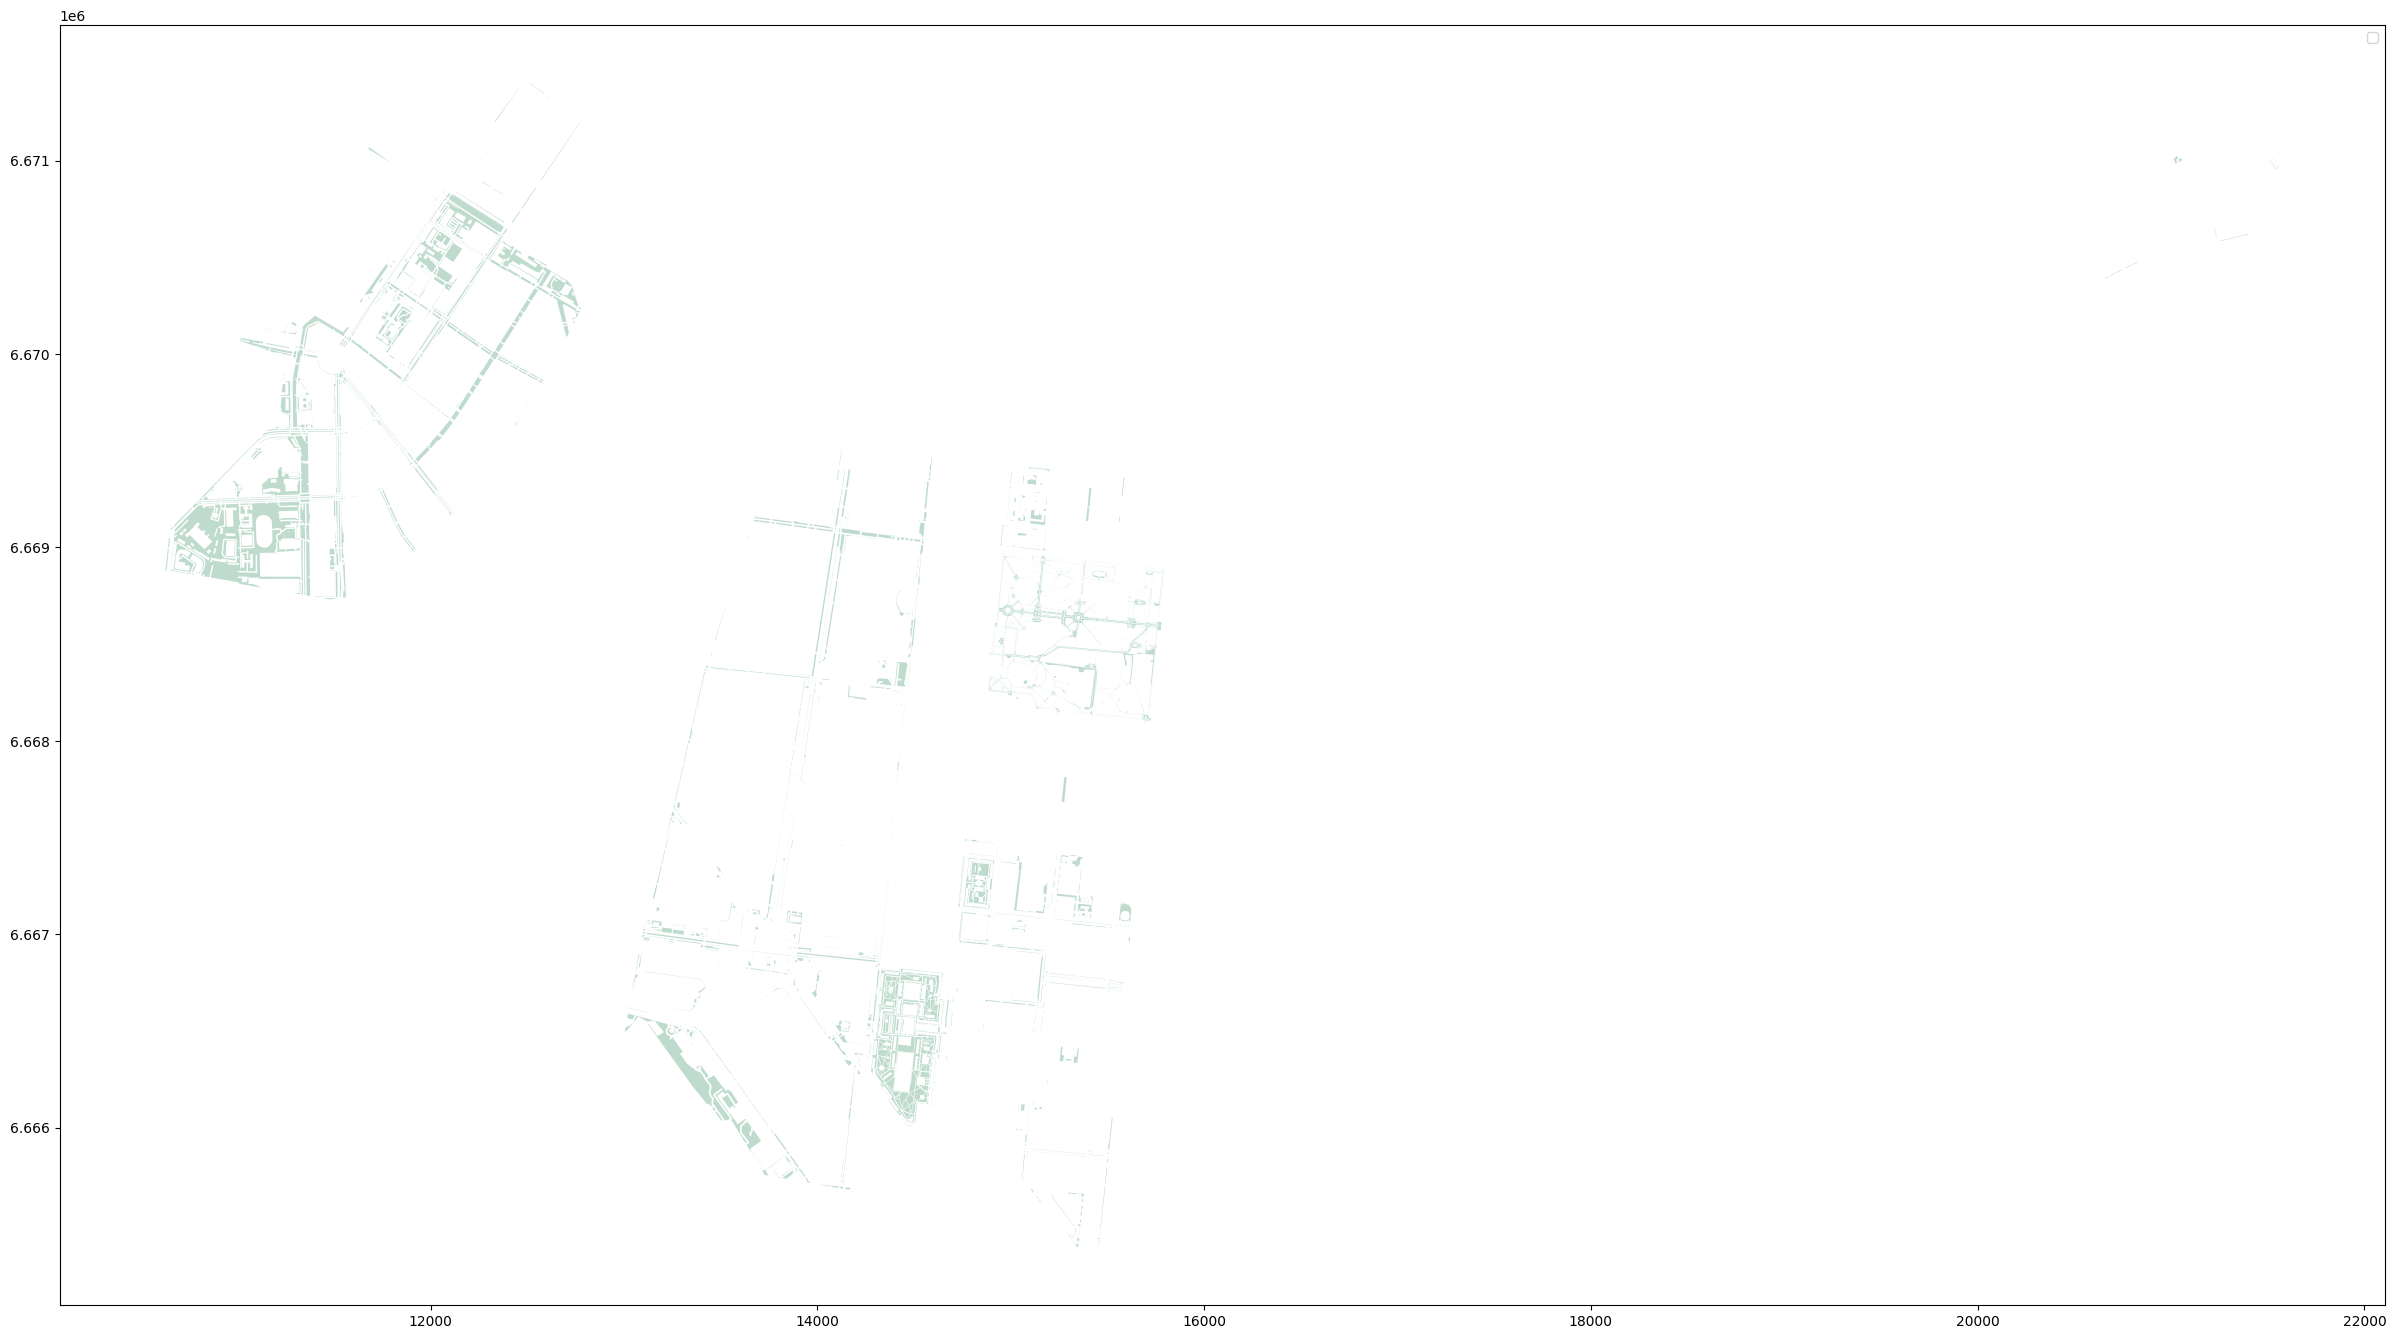

In [8]:
print(f"Исходная площадь: {processed_gdf.geometry.area.sum():.0f} м²")
print(f"Оставшаяся площадь: {result_gdf.geometry.area.sum():.0f} м²")
print(f"Процент сохраненной площади: {result_gdf.geometry.area.sum() / processed_gdf.geometry.area.sum() * 100:.1f}%")

# Визуализация
fig, ax = plt.subplots(figsize=(30, 26))
# processed_gdf.plot(ax=ax, color='blue', alpha=0.5, label='Исходные полигоны')
result_gdf.plot(ax=ax, color='#a3cdb9', alpha=0.7, label='После вычитания дорожных буферов')
# features_gdf.plot(ax=ax, color='red', linewidth=1, alpha=0.1, label='Дороги')
plt.legend()
plt.show()

Дробление результат для применения следующих расчётов

In [9]:
if not result_gdf.empty:
  result_gdf = result_gdf.explode()
  result_gdf.to_file("free2.gpkg", driver="GPKG")

# Расчёт площади, которую можно отвести под озеленение

Создание функции расчёта максимальной площади озеленения.

Создание функции получения данных об необходимых объектах из osm

In [10]:
def get_osm_data_by_bbox(free_zones_gdf, buffer_m=100):
    free_zones_wgs = free_zones_gdf.to_crs(epsg=4326)
    bounds = free_zones_wgs.geometry.total_bounds
    buf_deg = buffer_m / 111320
    bbox = (bounds[0]-buf_deg, bounds[1]-buf_deg, bounds[2]+buf_deg, bounds[3]+buf_deg)
    tags = {'building': True, 'power': ['line','cable'], 'waterway': True}
    try:
        gdf = ox.features.features_from_bbox(bbox=bbox, tags=tags)
    except Exception as e:
        print(f"Ошибка загрузки OSM: {e}")
        return None
    gdf = gdf[gdf.geometry.notnull()].copy()
    conditions = [
        gdf['building'].notnull(),
        gdf['power'].notnull(),
        gdf['waterway'].notnull()
    ]
    choices = ['buildings','roads','utilities','water']
    gdf['type'] = None
    for cond, choice in zip(conditions, choices):
        gdf.loc[cond, 'type'] = choice
    return gdf[['geometry','type']]

Создание функции расчёта площади, которую можно занять под озеленение

In [11]:
def calculate_greening_with_osm(free_zones_gdf):
    context = get_osm_data_by_bbox(free_zones_gdf)
    if context is None:
        print("Не удалось загрузить данные OSM")
        return None
    result = free_zones_gdf.copy()
    for obj_type in context['type'].unique():
        objs = context[context['type'] == obj_type]
        if not objs.empty:
            if obj_type == 'roads':
                # Применяем буфер, основанный на минимальной ширине дороги
                buffers = []
                for _, row in objs.iterrows():
                    width = combined_buffer  # Получаем ширину дороги
                buffer_union = gpd.GeoSeries(buffers).unary_union  # Объединяем все буферы
                result.geometry = result.geometry.difference(buffer_union)
            else:
                # Для других типов объектов используем фиксированные отступы
                setback = {'buildings': 3.0, 'utilities': 2.0, 'water': 5.0}.get(obj_type, 0)
                if setback > 0:
                    buffer = objs.geometry.buffer(setback).unary_union
                    result.geometry = result.geometry.difference(buffer)
    result = result[result.geometry.area >= 5]
    result['area_m2'] = result.geometry.area
    result['trees_m2'] = result['area_m2'] * 0.3
    result['bushes_m2'] = result['area_m2'] * 0.2
    result['complex_m2'] = result['area_m2'] * 0.5
    return result

Применение функций

In [12]:
if __name__ == "__main__":
    free_zones = result_gdf
    if free_zones.crs != 'EPSG:3857':
        free_zones = free_zones.to_crs('EPSG:3857')
    result = calculate_greening_with_osm(free_zones)
    if result is not None:
        result = result.explode(index_parts=False).reset_index(drop=True)
        result.to_file('greening_plan_optimized.gpkg', driver='GPKG')
        print("Итоговые площади озеленения:")
        print(f"- Деревья: {result['trees_m2'].sum()/10000:.0f} га")
        print(f"- Кустарники: {result['bushes_m2'].sum()/10000:.0f} га")
        print(f"- Комплексное: {result['complex_m2'].sum()/10000:.0f} га")
    else:
        print("Расчет не выполнен из-за ошибок")

/tmp/ipython-input-11-3406546701.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = objs.geometry.buffer(setback).unary_union
/tmp/ipython-input-11-3406546701.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer = objs.geometry.buffer(setback).unary_union
/tmp/ipython-input-11-3406546701.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = objs.geometry.buffer(setback).unary_union
/tmp/ipython-input-11-3406546701.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer = objs.geometry.buffer(setback).unary_union


Итоговые площади озеленения:
- Деревья: 86 га
- Кустарники: 58 га
- Комплексное: 144 га


/tmp/ipython-input-11-3406546701.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = gpd.GeoSeries(buffers).unary_union  # Объединяем все буферы


#  РАСЧЕТ ЧИСЛА ПАРКОВОЧНЫХ МЕСТ

СоздаОпределение нормативных ограничений для размещения парковочных мест

In [13]:
# Стандарты и распределение парковочных мест с нормативами
PARKING_STANDARDS = {
    'standard': {'width': 2.5, 'length': 5.0, 'driveway': 3.0, 'ratio': 0.70, 'color': '#1f77b4'},
    'disabled': {'width': 3.6, 'length': 5.0, 'driveway': 3.0, 'ratio': 0.05, 'color': '#ff7f0e'},
    'guest': {'width': 2.5, 'length': 5.0, 'driveway': 0.0, 'ratio': 0.15, 'color': '#ffbb78'},
    'ev': {'width': 2.5, 'length': 5.0, 'driveway': 3.0, 'ratio': 0.10, 'color': '#d62728'}
}
MIN_AREA = 25  # Минимальная площадь полигона

Создание функции отсева территорий, где нельзя расместить ни одного парковочного места

In [14]:
# Сортировка зон
def calculate_parking_sp_113(free_zones_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame | None:
    """
    Улучшенный расчёт с реалистичной упаковкой машиномест.
    Возвращает GeoDataFrame с подсчётом или None, если размещение невозможно.
    """
    results = []
    total_by_type = {typ: 0 for typ in PARKING_STANDARDS}
    for idx, zone in free_zones_gdf.iterrows():
        zone_geom = zone.geometry
        if zone_geom.area < MIN_AREA:
            continue

        spaces = estimate_realistic_capacity(zone_geom)

        if sum(spaces.values()) > 0:
            result_row = zone.copy()
            for typ, count in spaces.items():
                result_row[f"{typ}_spaces"] = count
                total_by_type[typ] += count

            result_row['total_spaces'] = sum(spaces.values())
            results.append(result_row)

    if not results:
        print("Нет зон, пригодных для парковки.")
        return None

    return gpd.GeoDataFrame(results, crs=free_zones_gdf.crs)

Создание функции расчёта ёмкости одного парковочного места

In [15]:
# Оценка ёмкости одного полигона
def estimate_realistic_capacity(geom) -> dict:
    """
    Реалистичная оценка ёмкости для одного полигона.
    Возвращает словарь с количеством мест по типам.
    """
    area = geom.area
    effective_area = area * 0.65  # Учёт потерь на проезды и манёвры
    std_spaces = int(effective_area / 12.5)  # 2.5x5 м + половина проезда

    disabled_spaces = max(1, int(std_spaces * 0.05))
    ev_spaces = max(1, int(std_spaces * 0.1))
    guest_spaces = int(std_spaces * 0.15)

    total = std_spaces + disabled_spaces + ev_spaces + guest_spaces
    if total < 5:  # Не размещаем микро-парковки
        return {typ: 0 for typ in PARKING_STANDARDS}

    return {
        'standard': std_spaces - (disabled_spaces + ev_spaces + guest_spaces),
        'disabled': disabled_spaces,
        'guest': guest_spaces,
        'ev': ev_spaces
    }

Создание функции для наглядного вывода результатов расчётов

In [16]:
# Визуализация
def plot_parking_results(parking_gdf: gpd.GeoDataFrame, title: str, sizes: np.ndarray):
    if parking_gdf.empty:
        print("Нет данных для отображения парковочных мест.")
        return

    centroids = parking_gdf.geometry.centroid
    fig, ax = plt.subplots(figsize=(16, 12), facecolor='white')
    fig.suptitle(title, fontsize=24, fontweight='bold', color='#111111', y=0.95)

    parking_gdf.plot(ax=ax, facecolor='none', edgecolor='#777777', linewidth=0.1)
    scatter = ax.scatter(
        centroids.x, centroids.y,
        s=sizes,
        c=sizes,
        cmap='YlOrRd',
        alpha=0.8,
        edgecolors='black',
        linewidth=0.1
    )

    cbar = fig.colorbar(scatter, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Количество парковочных мест', fontsize=14)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.margins(0.05)
    plt.show()
def plot_parking_results_with_centroids(parking_gdf: gpd.GeoDataFrame):
    total_spaces = parking_gdf['total_spaces']
    sizes = ((total_spaces / total_spaces.max()) * (1200 - 50)) + 50
    plot_parking_results(parking_gdf, "Распределение парковочных мест по центроидам зон", sizes)
def plot_parking_results_relative(parking_gdf: gpd.GeoDataFrame):
    total_spaces = parking_gdf['total_spaces']
    relative_sizes = (total_spaces / total_spaces.mean()) * 100
    plot_parking_results(parking_gdf, "Относительное распределение парковочных мест", relative_sizes)

def print_parking_stats(parking_gdf: gpd.GeoDataFrame):
    """Выводит статистику по категориям парковочных мест"""
    if parking_gdf.empty:
        print("Нет данных о парковочных местах")
        return

    # Суммируем места по категориям
    stats = {
        'standard': parking_gdf['standard_spaces'].sum(),
        'disabled': parking_gdf['disabled_spaces'].sum(),
        'guest': parking_gdf['guest_spaces'].sum(),
        'ev': parking_gdf['ev_spaces'].sum()
    }

    total = sum(stats.values())

    # Форматируем вывод
    print("\n=== Статистика парковочных мест ===")
    print(f"Всего мест: {total}")
    print("-------------------------------")
    for typ, count in stats.items():
        standard = PARKING_STANDARDS[typ]
        print(f"{typ:>9}: {count:4} ({count/total:.1%}) | "
              f"Размер: {standard['width']}x{standard['length']} м, "
              f"Цвет: {standard['color']}")
    print("-------------------------------")
    print(f"Соответствие нормативам: "
          f"Гостевые {stats['guest']/total:.1%} (норма 15%), "
          f"Для инвалидов {stats['disabled']/total:.1%} (норма 5%), "
          f"Электромобили {stats['ev']/total:.1%} (норма 10%)")

def print_total_parking_area(parking_gdf: gpd.GeoDataFrame):
    """Выводит общую площадь всех парковочных мест"""
    if parking_gdf.empty:
        print("Нет данных о парковочных местах")
        return

    # Простой расчёт: сумма (количество мест * площадь одного места)
    total_area = (
        parking_gdf['standard_spaces'].sum() * 12.5 +  # 2.5x5 м
        parking_gdf['disabled_spaces'].sum() * 18.0 +  # 3.6x5 м
        parking_gdf['guest_spaces'].sum() * 12.5 +     # 2.5x5 м
        parking_gdf['ev_spaces'].sum() * 12.5          # 2.5x5 м
    )

    print(f"\nОбщая площадь парковочных мест: {total_area:.0f} м²")

Вызов всех функций


=== Расчёт парковочных мест ===

=== Статистика парковочных мест ===
Всего мест: 36526
-------------------------------
 standard: 25840 (70.7%) | Размер: 2.5x5.0 м, Цвет: #1f77b4
 disabled: 2121 (5.8%) | Размер: 3.6x5.0 м, Цвет: #ff7f0e
    guest: 4924 (13.5%) | Размер: 2.5x5.0 м, Цвет: #ffbb78
       ev: 3641 (10.0%) | Размер: 2.5x5.0 м, Цвет: #d62728
-------------------------------
Соответствие нормативам: Гостевые 13.5% (норма 15%), Для инвалидов 5.8% (норма 5%), Электромобили 10.0% (норма 10%)

Общая площадь парковочных мест: 468240 м²


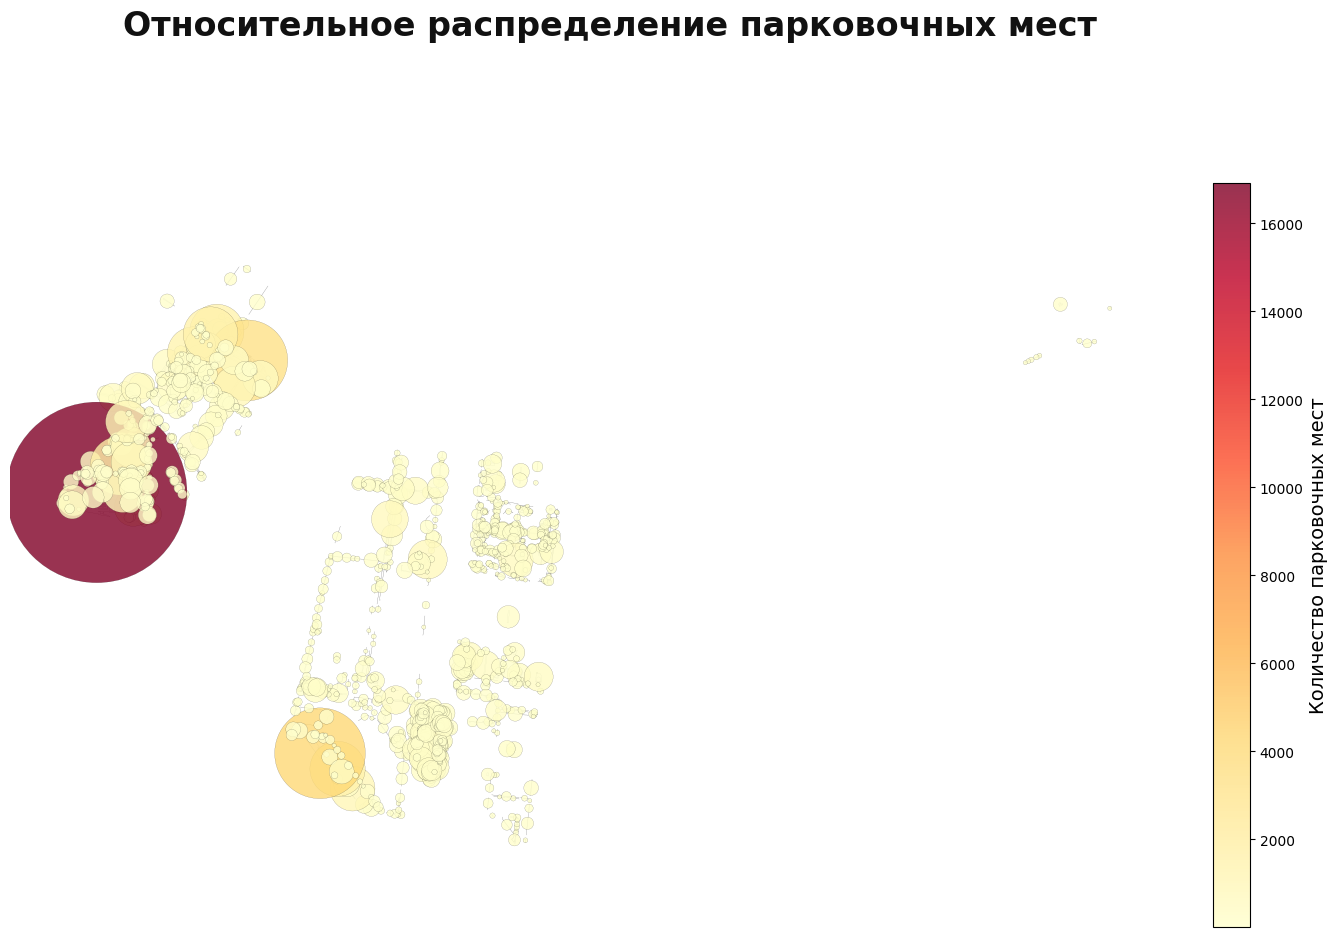


Сохранено 1104 зон с 36526 местами


In [17]:
# Вызов функций. result_gdf - GeoDataFrame для всех операций
if __name__ == "__main__":
    if 'result_gdf' not in globals() or result_gdf.empty:
        print("Ошибка: Нет данных для расчёта (result_gdf не определён или пуст)")
        exit()

    print("\n=== Расчёт парковочных мест ===")
    parking_gdf = calculate_parking_sp_113(result_gdf)

    if parking_gdf is None:
        print("Не удалось разместить парковочные места")
        exit()

    # Вывод статистики
    print_parking_stats(parking_gdf)
    print_total_parking_area(parking_gdf)

    # Визуализация и сохранение
    plot_parking_results_relative(parking_gdf)
    parking_gdf.to_file("parking_results.gpkg", driver="GPKG") # вывод результата в файл
    print(f"\nСохранено {len(parking_gdf)} зон с {parking_gdf['total_spaces'].sum()} местами")